In [3]:
from PIL import Image
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

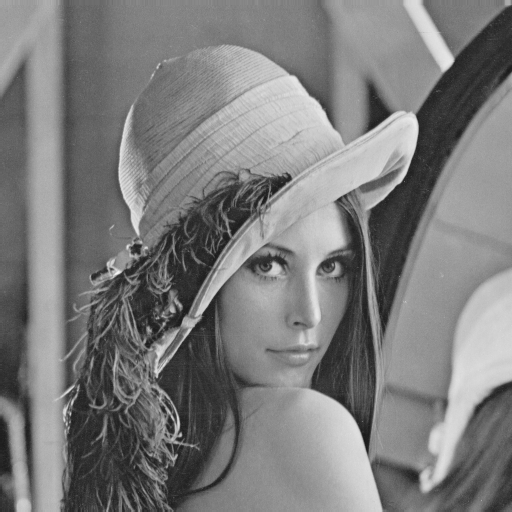

In [4]:
lena_image = Image.open("no_index/lena.png").convert("L")
lena_image

In [46]:
def compute_harris_response(img, sigma):
    imx = np.zeros_like(img) * 1.0
    gaussian_filter(img, (sigma, sigma), (0, 1), imx)
    imy = np.zeros_like(img) * 1.0
    gaussian_filter(img, (sigma, sigma), (1, 0), imy)
    
    Wxx = gaussian_filter(imx * imx, sigma)
    Wyy = gaussian_filter(imy * imy, sigma)
    Wxy = gaussian_filter(imx * imy, sigma)
    
    det = Wxx * Wyy - Wxy ** 2
    tr = (Wxx + Wyy)
    return det / tr

In [47]:
def get_harris_points(harris_matrix: np.array, min_dist=10, threshold=0.05):
    # find top corner coordinates above threshold
    corner_threshold = harris_matrix.max() * threshold
    harris_matrix_t = (harris_matrix > corner_threshold).astype(bool)
    
    # Coordinates of harris matrix
    coords = np.array(harris_matrix_t.nonzero()).T # (2 x num_coors) -> (num_coors x 2)
    
    # Find best harris matrix candidates
    candidate_values = [harris_matrix[c[0], c[1]] for c in coords]
    indices = np.argsort(candidate_values)
    
    # store allowed point locations in array
    allowed_locations = np.zeros_like(harris_matrix)
    allowed_locations[min_dist: -min_dist, min_dist:-min_dist] = 1
    
    # selected the best points taking min_distance into account
    filtered_coords = []
    for idx in indices:
        if allowed_locations[coords[idx, 0], coords[idx, 1]] == 1:
            filtered_coords.append(coords[idx])
            allowed_locations[coords[idx, 0] - min_dist: coords[idx, 0] + min_dist, coords[idx, 1] - min_dist: coords[idx, 1] + min_dist] = 0
            
    return filtered_coords

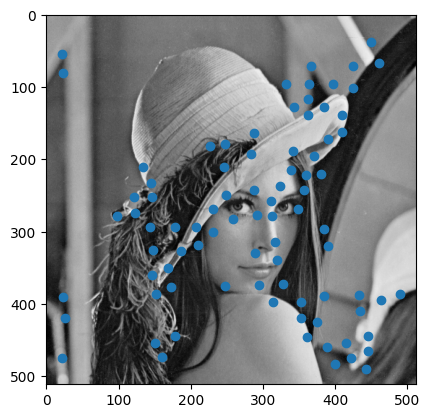

In [48]:
harris_matrix = compute_harris_response(np.array(lena_image), sigma=6)
harris_points = np.array(get_harris_points(harris_matrix, min_dist=20, threshold=0.1))
harris_points_X = [c[1] for c in harris_points]
harris_points_Y = [c[0] for c in harris_points]

plt.imshow(lena_image, cmap='gray')
plt.scatter(harris_points_X, harris_points_Y)